In [1]:
# !pip install pandas kagglehub ultralytics tensorboard onnx

%matplotlib inline

In [2]:
import os
import random
import shutil
import glob

import kagglehub
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

/home/buklinfur/projects/4semester_ai/DL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("imadeddinelassakeur/heridal")

print("Path to dataset files:", path)

data_dir = path

Path to dataset files: /home/buklinfur/.cache/kagglehub/datasets/imadeddinelassakeur/heridal/versions/1


In [ ]:
src_dir = os.path.join(data_dir, "train")
label_path = os.path.join(src_dir, "_annotations.csv")

out_dir = os.path.abspath('dataset')
out_images_dir = os.path.join(out_dir, "images")
out_labels_dir = os.path.join(out_dir, "labels")

def split_dataset():
    ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

    random.seed(42)

    for split in ratios:
        os.makedirs(os.path.join(out_images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(out_labels_dir, split), exist_ok=True)

    print(f"Reading annotations from {label_path}...")
    df = pd.read_csv(label_path)

    class_map = {"human": 0}
    df["class_id"] = df["class"].map(class_map)

    all_files = df["filename"].unique().tolist()
    random.shuffle(all_files)

    n = len(all_files)
    n_train = int(ratios["train"] * n)
    n_val = int(ratios["val"] * n)

    splits = {
        "train": all_files[:n_train],
        "val": all_files[n_train:n_train + n_val],
        "test": all_files[n_train + n_val:],
    }

    for split, filenames in splits.items():
        print(f"Processing {split} set: {len(filenames)} images")
        for fname in filenames:
            src_img = os.path.join(src_dir, fname)
            dst_img = os.path.join(out_images_dir, split, fname)
            shutil.copy(src_img, dst_img)

            records = df[df["filename"] == fname]

            label_file = os.path.join(out_labels_dir, split, fname.replace(".jpg", ".txt"))
            with open(label_file, "w") as lf:
                for _, row in records.iterrows():
                    x_center = ((row.xmin + row.xmax) / 2) / row.width
                    y_center = ((row.ymin + row.ymax) / 2) / row.height
                    w = (row.xmax - row.xmin) / row.width
                    h = (row.ymax - row.ymin) / row.height
                    lf.write(f"{row.class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    print("\nDataset splitting complete.")
    print({split: len(files) for split, files in splits.items()})

# split_dataset()

Reading annotations from /home/buklinfur/.cache/kagglehub/datasets/imadeddinelassakeur/heridal/versions/1/train/_annotations.csv...
Processing train set: 788 images
Processing val set: 98 images
Processing test set: 99 images

Dataset splitting complete.
{'train': 788, 'val': 98, 'test': 99}


In [ ]:
model = YOLO('yolov8m.pt')
model.train(
    data='/home/buklinfur/projects/4semester_ai/DL/lab3/heridal.yaml',
    epochs=300,
    device=0,
    imgsz=1184,
    batch=4,
    single_cls=True,
    workers=2,
    
    optimizer='AdamW', # default wait decay = 5e-4
    lr0=1e-3,
    lrf=1e-6,
    cos_lr=True,

    cutmix=0.3,
    hsv_v=0.6,
    hsv_s=0.5,
    hsv_h=0.005,

    name='yolov8n',
    save=True,
    save_period=25,
    resume=False
)

In [13]:
def show_sample(img_path, gt_boxes, pred_boxes):
    img_bgr = cv2.imread(img_path)
    img_gt   = img_bgr.copy()
    img_pred = img_bgr.copy()

    for x1,y1,x2,y2 in gt_boxes:
        cv2.rectangle(img_gt,   (x1,y1), (x2,y2), (0,255,0), 10)

    for x1,y1,x2,y2 in pred_boxes:
        cv2.rectangle(img_pred, (x1,y1), (x2,y2), (0,0,255), 10)

    img_gt   = cv2.cvtColor(img_gt,   cv2.COLOR_BGR2RGB)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

    fig,axs = plt.subplots(1,2,figsize=(12,6))
    axs[0].imshow(img_gt);   axs[0].set_title("Ground Truth"); axs[0].axis("off")
    axs[1].imshow(img_pred); axs[1].set_title("Predictions");  axs[1].axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
def random_inference(model, images_dir, labels_dir, n=5, conf=0.25, seed=None):
    if seed is not None:
        random.seed(seed)
    img_paths = glob.glob(os.path.join(images_dir, "*.jpg"))
    selected = random.sample(img_paths, min(n, len(img_paths)))
    for img_path in selected:

        img = cv2.imread(img_path)
        H,W = img.shape[:2]

        stem = os.path.splitext(os.path.basename(img_path))[0]
        gt_path = os.path.join(labels_dir, stem + ".txt")
        gt_boxes = []
        if os.path.exists(gt_path):
            for line in open(gt_path):
                cls, x_c, y_c, w, h = map(float, line.split())

                x1 = int((x_c - w/2) * W)
                y1 = int((y_c - h/2) * H)
                x2 = int((x_c + w/2) * W)
                y2 = int((y_c + h/2) * H)
                gt_boxes.append([x1,y1,x2,y2])

        res = model.predict(source=img_path, 
                            conf=conf, 
                            imgsz=1184)[0]
        pred_boxes = (res.boxes.xyxy.cpu().numpy().astype(int)).tolist()

        show_sample(img_path, gt_boxes, pred_boxes)


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_MED_4045_JPG.rf.0c47a725fb509d9e0fae21970dd68d88.jpg: 896x1184 2 items, 33.9ms
Speed: 6.3ms preprocess, 33.9ms inference, 1.2ms postprocess per image at shape (1, 3, 896, 1184)


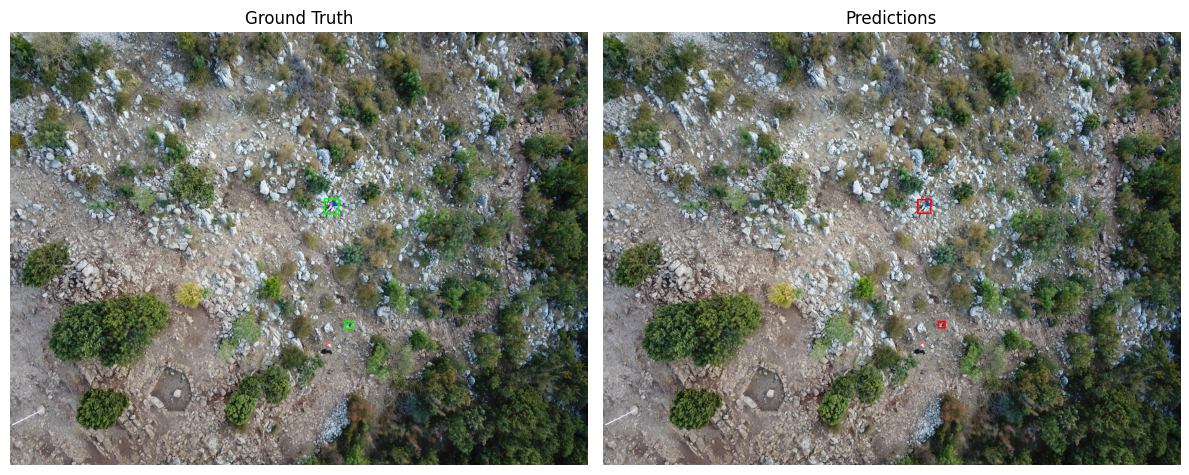


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_BRA_1053_JPG.rf.5e0b65f2acc23b3d1046f4f755714057.jpg: 896x1184 2 items, 7.8ms
Speed: 5.8ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 896, 1184)


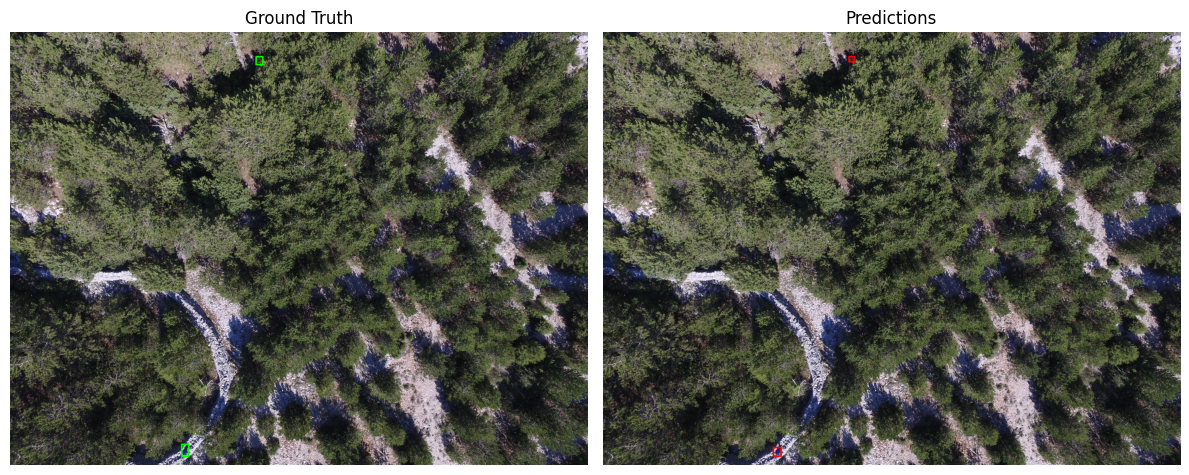


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_JAS_0133_JPG.rf.606dc5d28748898cd11c955ed62ffe7e.jpg: 896x1184 1 item, 7.9ms
Speed: 6.7ms preprocess, 7.9ms inference, 0.8ms postprocess per image at shape (1, 3, 896, 1184)


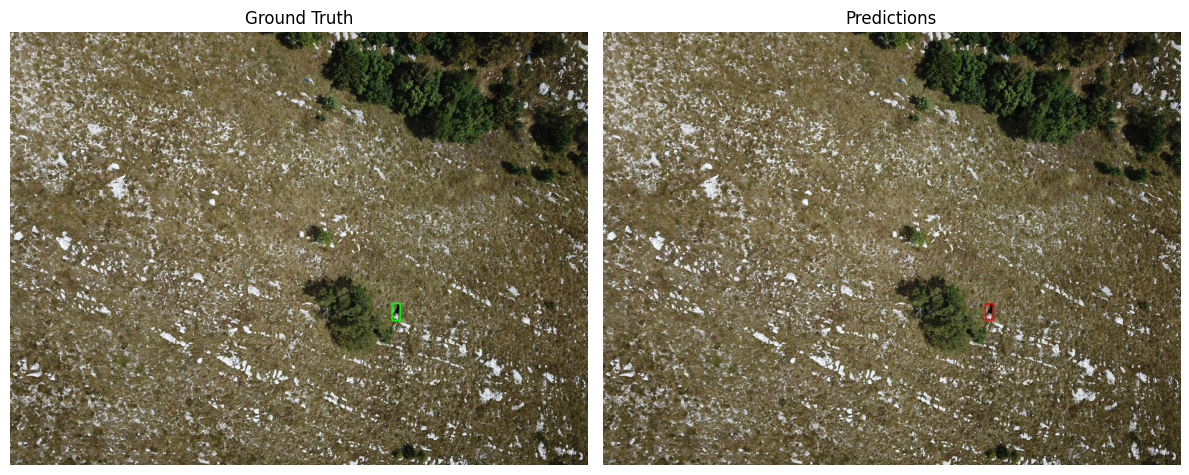


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_GOR_2009_JPG.rf.1ef12394bf4543711a2594b5b64d2787.jpg: 896x1184 1 item, 6.4ms
Speed: 4.8ms preprocess, 6.4ms inference, 1.7ms postprocess per image at shape (1, 3, 896, 1184)


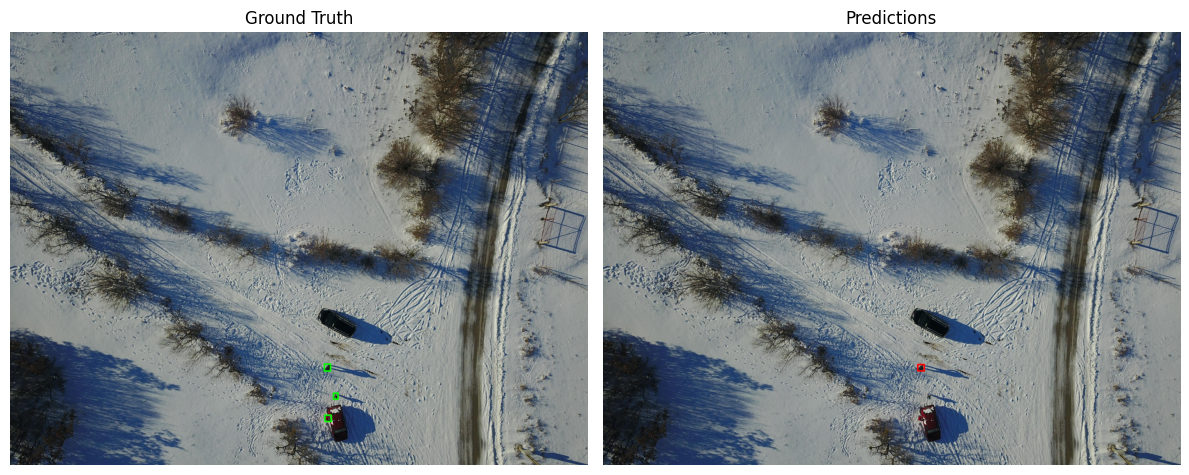


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_GOR_3033_JPG.rf.e9be991fad10d895c6c661607fb2f4b5.jpg: 896x1184 2 items, 6.7ms
Speed: 4.1ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 896, 1184)


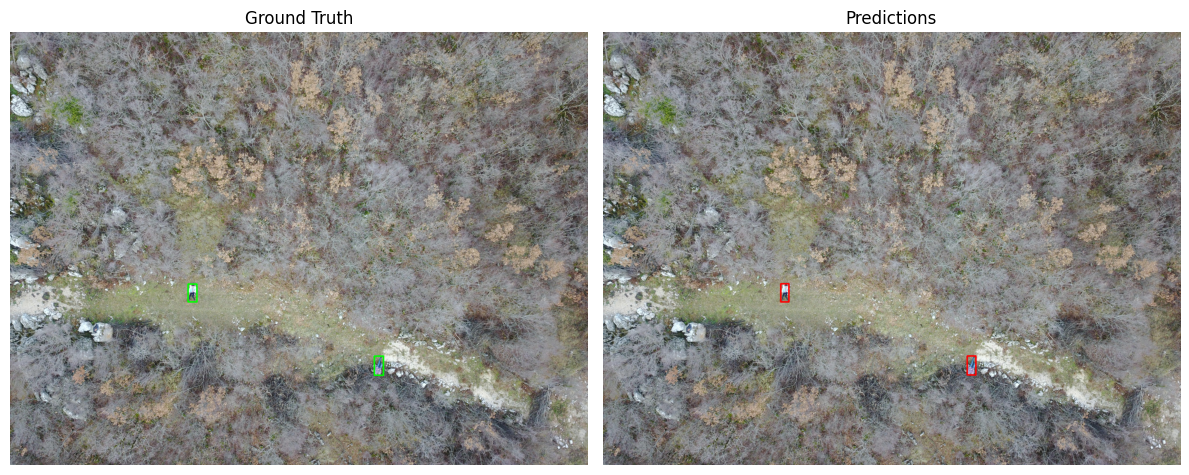


image 1/1 /home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test/train_VRD_0015_JPG.rf.1bb22434ea36f5efb552a50f975b3686.jpg: 896x1184 2 items, 7.9ms
Speed: 6.1ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 896, 1184)


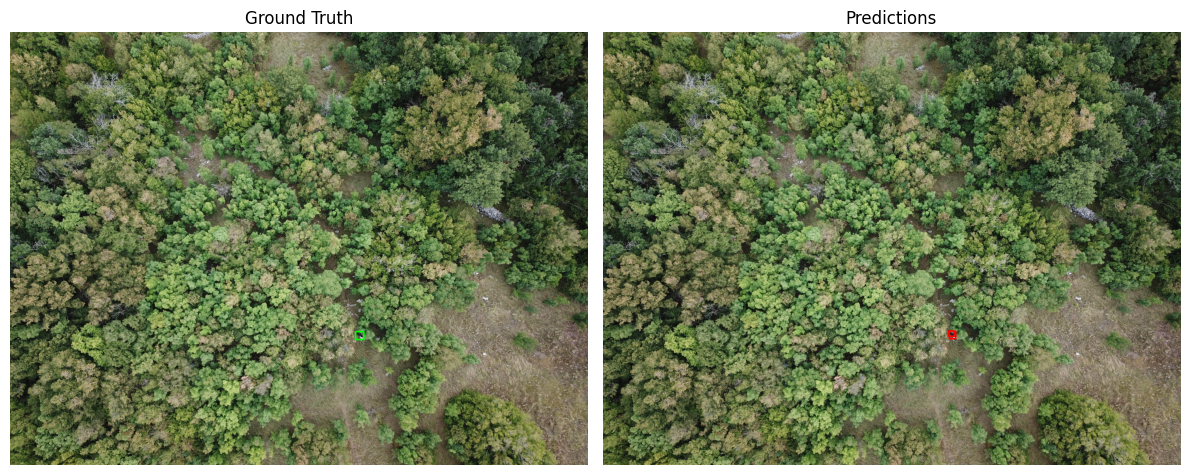

In [17]:
model = YOLO('runs/detect/yolov8n/weights/best.pt')

images_dir = "/home/buklinfur/projects/4semester_ai/DL/lab3/dataset/images/test"
labels_dir = "/home/buklinfur/projects/4semester_ai/DL/lab3/dataset/labels/test"

random_inference(model, images_dir, labels_dir, n=6, conf=0.3, seed=42)